## 데이터셋 다운로드

In [2]:
!git clone https://github.com/smartboy110/denoising-datasets.git

fatal: destination path 'denoising-datasets' already exists and is not an empty directory.


In [3]:
!pip install torchinfo

**DnCNN-B**: 블라인드 가우시안 노이즈(0~55) 제거를 위한 모델 - patch_size=50 <br>
DnCNN-B 모델의 손실 함수 MSE의 단점을 극복하기 위해 SRGAN의 Perceptual Loss를 활용해봄

In [19]:
import os
import copy
import time
import torch
import random
import numpy as np
from PIL import Image
from torchinfo import summary

import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import functional as F

In [47]:
class Config:
  #Path
  train_data_root = "denoising-datasets/BSD400"
  test_data_root = "denoising-datasets/BSD68"

  # Dataset
  patch_size = 50
  train_ratio=0.9
  patches_per_image = 200
  # DnCNN-B 노이즈
  sigma_range=(0,55)

  #Model
  num_layers=20
  in_channels=1
  out_channels=64
  kernel_size=3

  #Training
  batch_size=128
  num_epochs=50
  learning_rate=1e-3

  #GAN Loss 가중치
  lambda_mse=1.0
  lambda_perc=0.05
  lambda_adv=0.005

  path2weights = './DnCNN-B_PerceptualLoss.pth'

config = Config()

## Data Loading & Preprocessing

In [48]:
class DnCNN_Dataset(Dataset):
  def __init__(self, root, file_list, patch_size, sigma_range, patches_per_image=1000, is_train=True):
    self.root = root
    self.file_list = file_list
    self.patch_size = patch_size
    self.is_train = is_train
    # sigma
    self.sigma_min = sigma_range[0] / 255.0  # 0 / 255 = 0
    self.sigma_max = sigma_range[1] / 255.0  # 55 / 255 = 0.216
    self.patches_per_image = patches_per_image if is_train else 1

    if not is_train:
            self.fixed_data = []
            for idx in range(len(file_list)):
                img = Image.open(os.path.join(root, file_list[idx])).convert('L')
                img = np.array(img, dtype=np.float32) / 255.0
                h, w = img.shape[:2]
                top = random.randint(0, h - patch_size)
                left = random.randint(0, w - patch_size)
                patch = img[top:top+patch_size, left:left+patch_size]
                clean = torch.from_numpy(patch).unsqueeze(0)
                sigma = random.uniform(self.sigma_min, self.sigma_max)
                noise = torch.randn_like(clean) * sigma
                noisy = clean + noise
                self.fixed_data.append((noisy, clean))

  def __len__(self):
    return len(self.file_list)*self.patches_per_image

  def __getitem__(self, index):
    if not self.is_train:
            return self.fixed_data[index]
    img_idx = index % len(self.file_list)
    img = Image.open(os.path.join(self.root, self.file_list[img_idx])).convert('L')
    img = np.array(img, dtype=np.float32)/255.0

    h,w = img.shape[:2]
    top = random.randint(0, h-self.patch_size)
    left = random.randint(0, w-self.patch_size)

    patch = img[top:top+self.patch_size, left:left+self.patch_size]
    #Random Rotation + randomfilp 적용
    k = random.randint(0,3)
    patch = np.rot90(patch, k).copy()
    if random.random() >0.5:
        patch = np.fliplr(patch).copy() 
      
    # Tensor 변환
    clean = torch.from_numpy(patch).unsqueeze(0)

    # Gaussian noise 추가
    sigma = random.uniform(self.sigma_min, self.sigma_max)  # 0 ~ 0.216
    noise = torch.randn_like(clean) * sigma
    noisy = clean + noise
    '''
      # RGB 이미지일 경우
      img = Image.open(os.path.join(self.root, self.files[idx])).convert('RGB')
      img = np.array(img, dtype=np.float32) / 255.0

      h, w, c = img.shape
      i = np.random.randint(0, h - self.patch_size + 1)
      j = np.random.randint(0, w - self.patch_size + 1)

      patch = img[i:i+self.patch_size, j:j+self.patch_size, :]

      # [H, W, C] -> [C, H, W]
      clean = torch.from_numpy(patch).permute(2, 0, 1)

      sigma = random.uniform(self.sigma_min, self.sigma_max)  # 0 ~ 0.216
      noise = torch.randn_like(clean) * sigma
      noisy = clean + noise
      '''

    return noisy, clean

In [49]:
# 이미지 파일만 필터링
def get_image_files(directory):
    """
    디렉토리에서 이미지 파일만 필터링
    """
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    all_files = os.listdir(directory)
    image_files = [f for f in all_files
                   if os.path.splitext(f)[1].lower() in valid_extensions]
    return sorted(image_files)

train_files = get_image_files(config.train_data_root)
#test_files = get_image_files(config.test_data_root)
total = len(train_files)

train_end = int(config.train_ratio * total)

train_list = train_files[:train_end]
val_list = train_files[train_end:]
#test_list = test_files[::]

print(f'Total: {total}')
print(f'Train: {len(train_list)}')
print(f'Val:   {len(val_list)}')
#print(f'Test:  {len(test_list)}')

Total: 400
Train: 360
Val:   40



Sample Visualization: Noisy vs Clean
Sample 1:
  Clean range: [0.141, 0.792]
  Noisy range: [-0.124, 1.068]
  Noise std: 0.1352 (34.47/255)
Sample 2:
  Clean range: [0.443, 0.576]
  Noisy range: [-0.270, 1.247]
  Noise std: 0.2109 (53.78/255)
Sample 3:
  Clean range: [0.071, 0.984]
  Noisy range: [-0.219, 1.124]
  Noise std: 0.0874 (22.28/255)
Sample 4:
  Clean range: [0.227, 0.808]
  Noisy range: [0.090, 0.846]
  Noise std: 0.0778 (19.84/255)
Sample 5:
  Clean range: [0.165, 0.996]
  Noisy range: [0.025, 1.084]
  Noise std: 0.0684 (17.45/255)


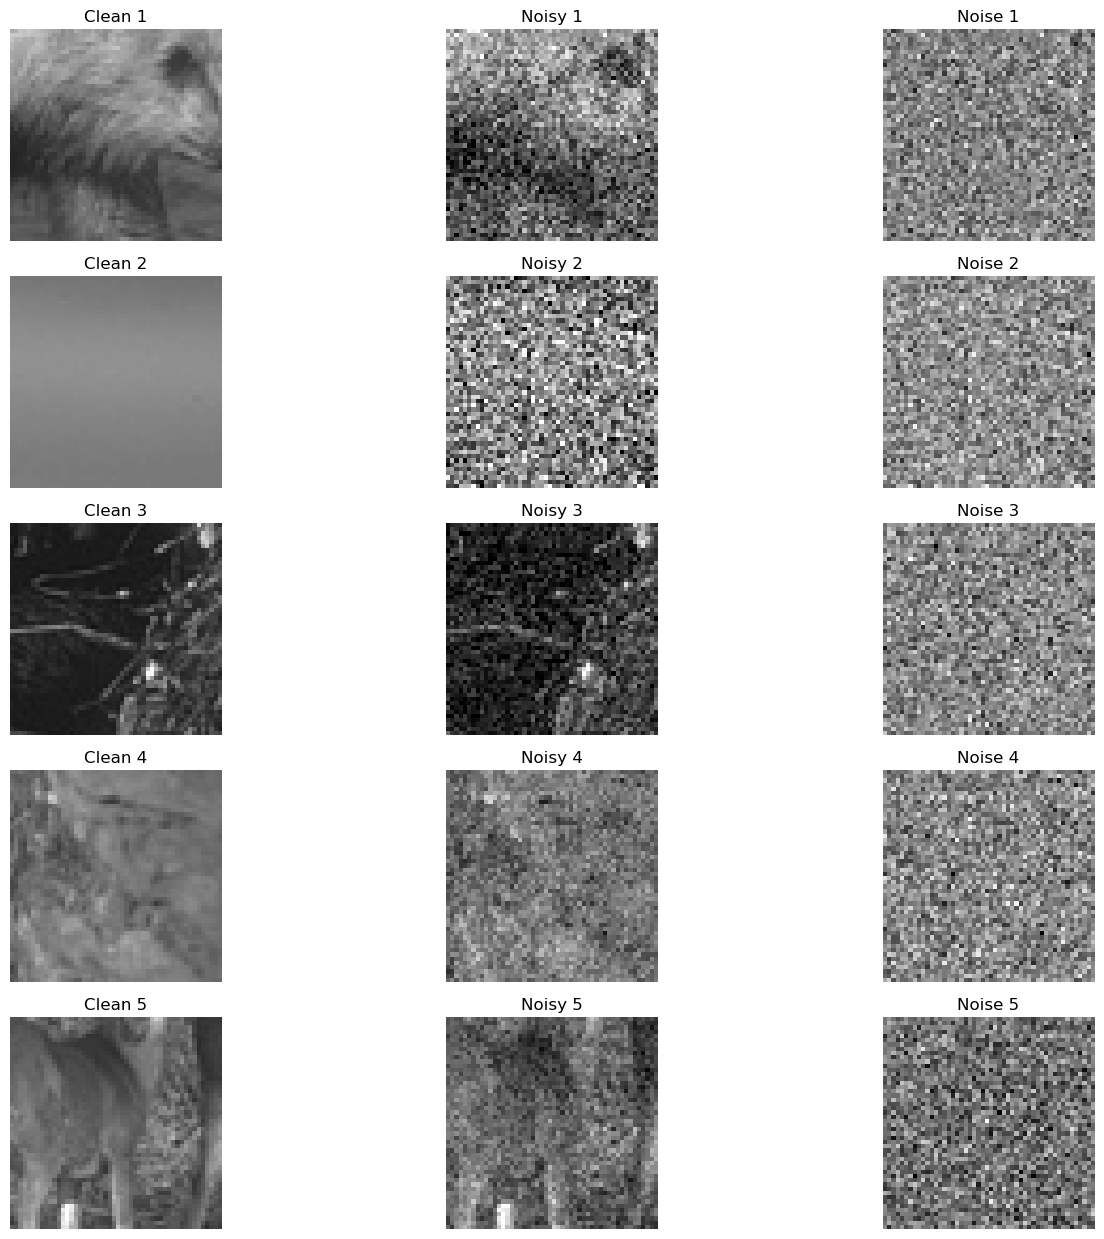

In [50]:
train_dataset = DnCNN_Dataset(
    root=config.train_data_root,
    file_list=train_list,
    patch_size=config.patch_size,
    sigma_range=config.sigma_range,
    patches_per_image=config.patches_per_image,
    is_train=True
)

val_dataset   = DnCNN_Dataset(
    config.train_data_root, 
    val_list,   
    config.patch_size,
    config.sigma_range, is_train=False
    )

def visualize_samples_debug(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*2.5))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        noisy, clean = dataset[i]

        # [1, H, W] -> [H, W]
        noisy_np = noisy.squeeze().numpy()
        clean_np = clean.squeeze().numpy()
        noise_np = (noisy - clean).squeeze().numpy()

        # 통계 정보
        print(f'Sample {i+1}:')
        print(f'  Clean range: [{clean_np.min():.3f}, {clean_np.max():.3f}]')
        print(f'  Noisy range: [{noisy_np.min():.3f}, {noisy_np.max():.3f}]')
        print(f'  Noise std: {noise_np.std():.4f} ({noise_np.std()*255:.2f}/255)')

        # Clip to [0, 1] for visualization
        noisy_display = np.clip(noisy_np, 0, 1)
        clean_display = np.clip(clean_np, 0, 1)

        # Clean 이미지
        axes[i, 0].imshow(clean_display, cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Clean {i+1}')
        axes[i, 0].axis('off')

        # Noisy 이미지
        axes[i, 1].imshow(noisy_display, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f'Noisy {i+1}')
        axes[i, 1].axis('off')

        # Noise만 (시각화용)
        noise_display = noise_np - noise_np.min()
        noise_display = noise_display / (noise_display.max() + 1e-8)
        axes[i, 2].imshow(noise_display, cmap='gray')
        axes[i, 2].set_title(f'Noise {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# 샘플 시각화
print('\n' + '='*70)
print('Sample Visualization: Noisy vs Clean')
print('='*70)
visualize_samples_debug(train_dataset, num_samples=5)


In [51]:
def check_noise_levels(dataset, num_samples=10):
    """
    여러 샘플의 노이즈 레벨과 PSNR 확인
    """
    print('\n' + '='*70)
    print('Noise Level Check')

    for i in range(num_samples):
        noisy, clean = dataset[i]

        # MSE 계산
        mse = torch.mean((noisy - clean) ** 2).item()
        psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

        # 노이즈 강도 (std)
        noise = noisy - clean
        noise_std = torch.std(noise).item() * 255  # [0, 255] 스케일로 변환

        print(f'Sample {i+1}: Noise σ ≈ {noise_std:.2f}, PSNR: {psnr:.2f} dB')

check_noise_levels(train_dataset, num_samples=10)


Noise Level Check
Sample 1: Noise σ ≈ 30.17, PSNR: 18.54 dB
Sample 2: Noise σ ≈ 2.19, PSNR: 41.31 dB
Sample 3: Noise σ ≈ 54.14, PSNR: 13.46 dB
Sample 4: Noise σ ≈ 5.75, PSNR: 32.93 dB
Sample 5: Noise σ ≈ 33.00, PSNR: 17.76 dB
Sample 6: Noise σ ≈ 2.22, PSNR: 41.21 dB
Sample 7: Noise σ ≈ 34.40, PSNR: 17.40 dB
Sample 8: Noise σ ≈ 2.18, PSNR: 41.37 dB
Sample 9: Noise σ ≈ 25.44, PSNR: 20.02 dB
Sample 10: Noise σ ≈ 8.73, PSNR: 29.31 dB


## Model Architecture - Discriminator

In [52]:
class Discriminator(nn.Module):
    def __init__(self, in_channels: int =1):
        super(Discriminator, self).__init__()

        def conv_block(in_channels, out_channels, stride=1, use_bn=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        self.model = nn.Sequential(
            conv_block(in_channels, 32, stride=1, use_bn=False),
            conv_block(32,  64,  stride=2, use_bn=True),
            conv_block(64,  128, stride=2, use_bn=True),
            conv_block(128, 256, stride=2, use_bn=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1) 
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.model(x)


## Model Architecture - Generator

In [53]:
class DnCNN(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size):
    super(DnCNN, self).__init__()

    layers =[]
    padding = kernel_size // 2

    # First Layer
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
    layers.append(nn.ReLU(inplace=True))

    # Mid Layer
    for _ in range(depth-2):
      layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))

    # Last Layer
    layers.append(nn.Conv2d(out_channels, 1, kernel_size=kernel_size, padding=padding))

    self.dncnn = nn.Sequential(*layers)
    self._initialize_weights()

  # Weight Initialization
  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

  # Residual Learning 노이즈만 출력
  def forward(self, x):
    return self.dncnn(x)


## Perceptual Loss

In [54]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:9])  # relu2_2
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.criterion = nn.MSELoss()

    def forward(self, denoised, clean):
        if denoised.shape[1] == 1:
            denoised = denoised.repeat(1, 3, 1, 1)
            clean    = clean.repeat(1, 3, 1, 1)
        return self.criterion(self.feature_extractor(denoised),
                              self.feature_extractor(clean))

In [55]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [56]:
model = DnCNN(in_channels=config.in_channels, out_channels=config.out_channels, kernel_size=config.kernel_size, depth=config.num_layers).to(device)
summary(model, (128, config.in_channels, config.patch_size, config.patch_size), device=device)
# 왜 config.patch_size?
# 왜냐하면 입력을 patch로 crop해서 입력하기 때문에 patch size x patch size 이미지가 입력이 된다.

Layer (type:depth-idx)                   Output Shape              Param #
DnCNN                                    [128, 1, 50, 50]          --
├─Sequential: 1-1                        [128, 1, 50, 50]          --
│    └─Conv2d: 2-1                       [128, 64, 50, 50]         640
│    └─ReLU: 2-2                         [128, 64, 50, 50]         --
│    └─Conv2d: 2-3                       [128, 64, 50, 50]         36,928
│    └─BatchNorm2d: 2-4                  [128, 64, 50, 50]         128
│    └─ReLU: 2-5                         [128, 64, 50, 50]         --
│    └─Conv2d: 2-6                       [128, 64, 50, 50]         36,928
│    └─BatchNorm2d: 2-7                  [128, 64, 50, 50]         128
│    └─ReLU: 2-8                         [128, 64, 50, 50]         --
│    └─Conv2d: 2-9                       [128, 64, 50, 50]         36,928
│    └─BatchNorm2d: 2-10                 [128, 64, 50, 50]         128
│    └─ReLU: 2-11                        [128, 64, 50, 50]         --

In [57]:
def current_psnr(mse):
  if mse ==0:
    return float('inf')
  return 10*np.log10(1.0/mse)

In [58]:
def train_gan(generator, discriminator, perceptual_loss,
              adv_loss_fn, mse_loss_fn,
              optimizer_G, optimizer_D,
              train_loader, val_loader,
              device, config):

    best_val_psnr = 0.0
    best_weights  = None
    start_time    = time.time()

    history = {
        'train_G_loss': [], 'train_D_loss': [],
        'train_psnr':   [], 'val_psnr':    []
    }

    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        generator.train()
        discriminator.train()

        total_G, total_D, total_psnr, n = 0.0, 0.0, 0.0, 0

        # ── Train ──────────────────────────────────────────────────────
        for noisy, clean in train_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            B = noisy.size(0)

            denoised = noisy - generator(noisy)  

            # Discriminator 업데이트 -> Discriminator가 제대로 구별할 수 있도록 학습
            optimizer_D.zero_grad()
            D_real    = discriminator(clean)                        #clean 이미지를 넣었을 때 Discriminator가 내놓는 점수
            D_fake    = discriminator(denoised.detach())            #denoised 이미지를 넣었을 때 Discriminator가 내놓는 점수
            out_shape = D_real.shape  # 실제 출력 shape으로 레이블 생성
            real_labels = torch.full(out_shape, 0.9, device=device)     #해당 이미지는 진짜라고 알려주는 레이블
            fake_labels = torch.zeros(out_shape, device=device)         #해당 이미지는 가짜라고 알려주는 레이블
            loss_D = (adv_loss_fn(D_real, real_labels) +     #clean을 진짜라고 맞추는 손실
                      adv_loss_fn(D_fake, fake_labels)) * 0.5     #denoised를 가짜라고 맞추는 손실
            loss_D.backward()
            optimizer_D.step()

            # Generator 업데이트
            optimizer_G.zero_grad()
            real_labels_G = torch.ones(out_shape, device=device)
            # denoised된 이미지를 진짜라고 출력하면 생성자가 잘 만든 것이기에 손실 낮아짐
            loss_G = (config.lambda_mse  * mse_loss_fn(denoised, clean) +
                      config.lambda_perc * perceptual_loss(denoised, clean) +
                      config.lambda_adv  * adv_loss_fn(discriminator(denoised), real_labels_G))
            loss_G.backward()
            optimizer_G.step()

            with torch.no_grad():
                mse_v = mse_loss_fn(denoised, clean).item()
                total_psnr += current_psnr(mse_v) * B
            total_G += loss_G.item() * B
            total_D += loss_D.item() * B
            n += B

        train_G_loss = total_G / n
        train_D_loss = total_D / n
        train_psnr   = total_psnr / n

        # ── Validation ─────────────────────────────────────────────────
        generator.eval()
        val_psnr_sum, val_n = 0.0, 0
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                denoised = noisy - generator(noisy)
                mse_v    = mse_loss_fn(denoised, clean).item()
                val_psnr_sum += current_psnr(mse_v) * noisy.size(0)
                val_n        += noisy.size(0)
        val_psnr = val_psnr_sum / val_n

        # ── 출력 ───────────────────────────────────────────────────────
        epoch_time   = time.time() - epoch_start
        elapsed_time = time.time() - start_time

        print(f'\n{"="*70}')
        print(f'Epoch [{epoch+1}/{config.num_epochs}]  '
              f'({epoch_time:.1f}s, total {elapsed_time/60:.1f}min')
        print(f'  G Loss: {train_G_loss:.6f}  |  D Loss: {train_D_loss:.6f}')
        print(f'  Train PSNR: {train_psnr:.2f} dB  |  Val PSNR: {val_psnr:.2f} dB')

        # ── History & 저장 ─────────────────────────────────────────────
        history['train_G_loss'].append(train_G_loss)
        history['train_D_loss'].append(train_D_loss)
        history['train_psnr'].append(train_psnr)
        history['val_psnr'].append(val_psnr)

        if val_psnr > best_val_psnr:
            best_val_psnr = val_psnr
            best_weights  = copy.deepcopy(generator.state_dict())
            torch.save(generator.state_dict(), config.path2weights)
            print(f'  ✓ Best Generator saved! (PSNR: {val_psnr:.2f} dB)')

    generator.load_state_dict(best_weights)
    total_time = time.time() - start_time
    print(f'\n{"="*70}')
    print(f'Training completed in {total_time/60:.1f} minutes')
    print(f'Best Val PSNR: {best_val_psnr:.2f} dB')
    print(f'{"="*70}')

    return history

In [59]:
def plot_results(history):
    epochs = range(1, len(history['train_G_loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(epochs, history['train_G_loss'], 'b-', label='G Loss', linewidth=2)
    axes[0].plot(epochs, history['train_D_loss'], 'r-', label='D Loss', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].set_title('GAN Loss', fontweight='bold')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['train_psnr'], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_psnr'],   'r-', label='Val',   linewidth=2)
    best_epoch = np.argmax(history['val_psnr']) + 1
    best_psnr  = max(history['val_psnr'])
    axes[1].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('PSNR (dB)')
    axes[1].set_title(f'PSNR (Best: {best_psnr:.2f}dB at epoch {best_epoch})', fontweight='bold')
    axes[1].legend(); axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def show_denoising_results(generator, dataloader, device, num_samples=5):
    generator.eval()
    noisy_list, clean_list, denoised_list = [], [], []

    with torch.no_grad():
        for noisy, clean in dataloader:
            noisy, clean = noisy.to(device), clean.to(device)
            denoised = noisy - generator(noisy)
            noisy_list.append(noisy.cpu())
            clean_list.append(clean.cpu())
            denoised_list.append(denoised.cpu())
            if len(noisy_list) * noisy.size(0) >= num_samples:
                break

    noisy_all    = torch.cat(noisy_list,    dim=0)[:num_samples]
    clean_all    = torch.cat(clean_list,    dim=0)[:num_samples]
    denoised_all = torch.cat(denoised_list, dim=0)[:num_samples]

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        noisy_img    = np.clip(noisy_all[i].squeeze().numpy(),    0, 1)
        clean_img    = np.clip(clean_all[i].squeeze().numpy(),    0, 1)
        denoised_img = np.clip(denoised_all[i].squeeze().numpy(), 0, 1)

        mse  = np.mean((denoised_img - clean_img) ** 2)
        psnr = current_psnr(mse)

        axes[i, 0].imshow(noisy_img,    cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title('Noisy');                axes[i, 0].axis('off')
        axes[i, 1].imshow(denoised_img, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f'Denoised (PSNR: {psnr:.2f}dB)'); axes[i, 1].axis('off')
        axes[i, 2].imshow(clean_img,    cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title('Clean (GT)');           axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [60]:
# 데이터 확인
print(f'Train: {len(train_list)}, Val: {len(val_list)}')

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=config.batch_size, shuffle=False)


# 모델 불러오기
generator  = DnCNN(config.in_channels, config.out_channels,
                       config.num_layers,  config.kernel_size).to(device)
discriminator = Discriminator(in_channels=config.in_channels).to(device)
perceptual    = PerceptualLoss().to(device)

# 기존 학습된 가중치 로드 (있으면) → 안정적인 GAN fine-tuning을 위해 권장
pretrained_path = './DnCNN-B(base).pth'
if os.path.exists(pretrained_path):
    generator.load_state_dict(torch.load(pretrained_path, map_location=device))
    print(f'✓ Pretrained weights loaded from {pretrained_path}')
else:
    print('Pretrained weights not found. Training from scratch.')

# Optimizer (D는 G보다 LR 낮게 → D가 너무 강해지지 않도록)
optimizer_G = torch.optim.Adam(generator.parameters(),     lr=config.learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config.learning_rate * 0.1)

# Loss 함수
adv_loss = nn.BCEWithLogitsLoss()
mse_loss = nn.MSELoss()


Train: 360, Val: 40
✓ Pretrained weights loaded from ./DnCNN-B(base).pth



Epoch [1/50]  (441.0s, total 7.4min
  G Loss: 0.112524  |  D Loss: 0.813283
  Train PSNR: 18.59 dB  |  Val PSNR: 12.90 dB
  ✓ Best Generator saved! (PSNR: 12.90 dB)

Epoch [2/50]  (423.5s, total 14.4min
  G Loss: 0.069943  |  D Loss: 0.303190
  Train PSNR: 19.56 dB  |  Val PSNR: 20.81 dB
  ✓ Best Generator saved! (PSNR: 20.81 dB)

Epoch [3/50]  (423.6s, total 21.5min
  G Loss: 0.053120  |  D Loss: 0.397288
  Train PSNR: 21.61 dB  |  Val PSNR: 24.59 dB
  ✓ Best Generator saved! (PSNR: 24.59 dB)

Epoch [4/50]  (424.3s, total 28.5min
  G Loss: 0.031556  |  D Loss: 0.627328
  Train PSNR: 25.10 dB  |  Val PSNR: 24.47 dB

Epoch [5/50]  (425.4s, total 35.6min
  G Loss: 0.045563  |  D Loss: 0.411094
  Train PSNR: 22.32 dB  |  Val PSNR: 23.56 dB

Epoch [6/50]  (420.7s, total 42.6min
  G Loss: 0.031846  |  D Loss: 0.562236
  Train PSNR: 25.06 dB  |  Val PSNR: 25.07 dB
  ✓ Best Generator saved! (PSNR: 25.07 dB)

Epoch [7/50]  (422.8s, total 49.7min
  G Loss: 0.034455  |  D Loss: 0.469846
  Train

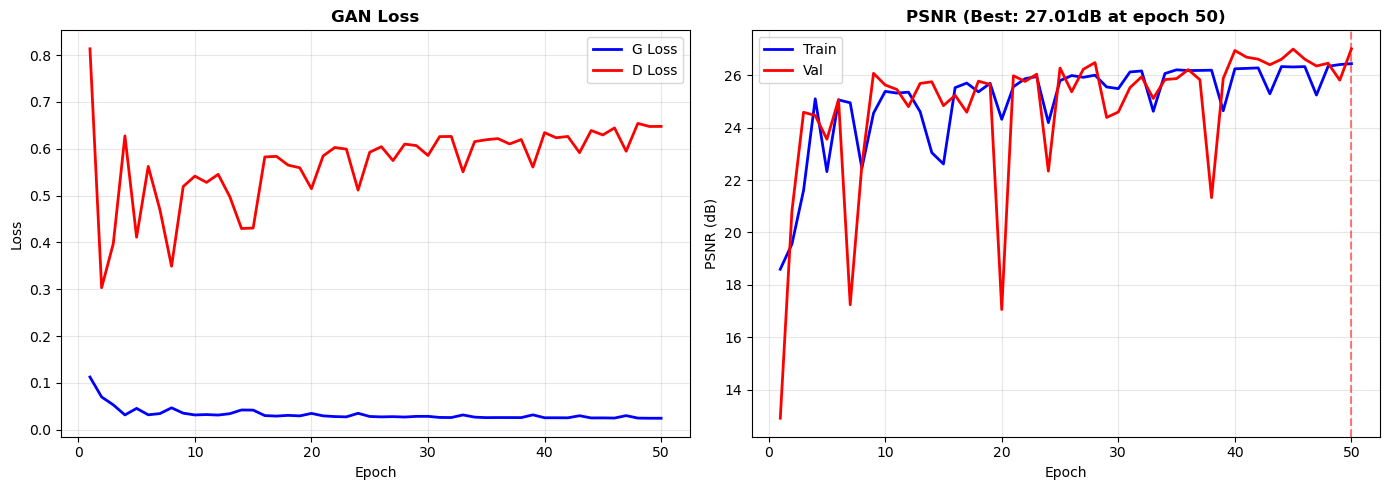


Denoising Results:


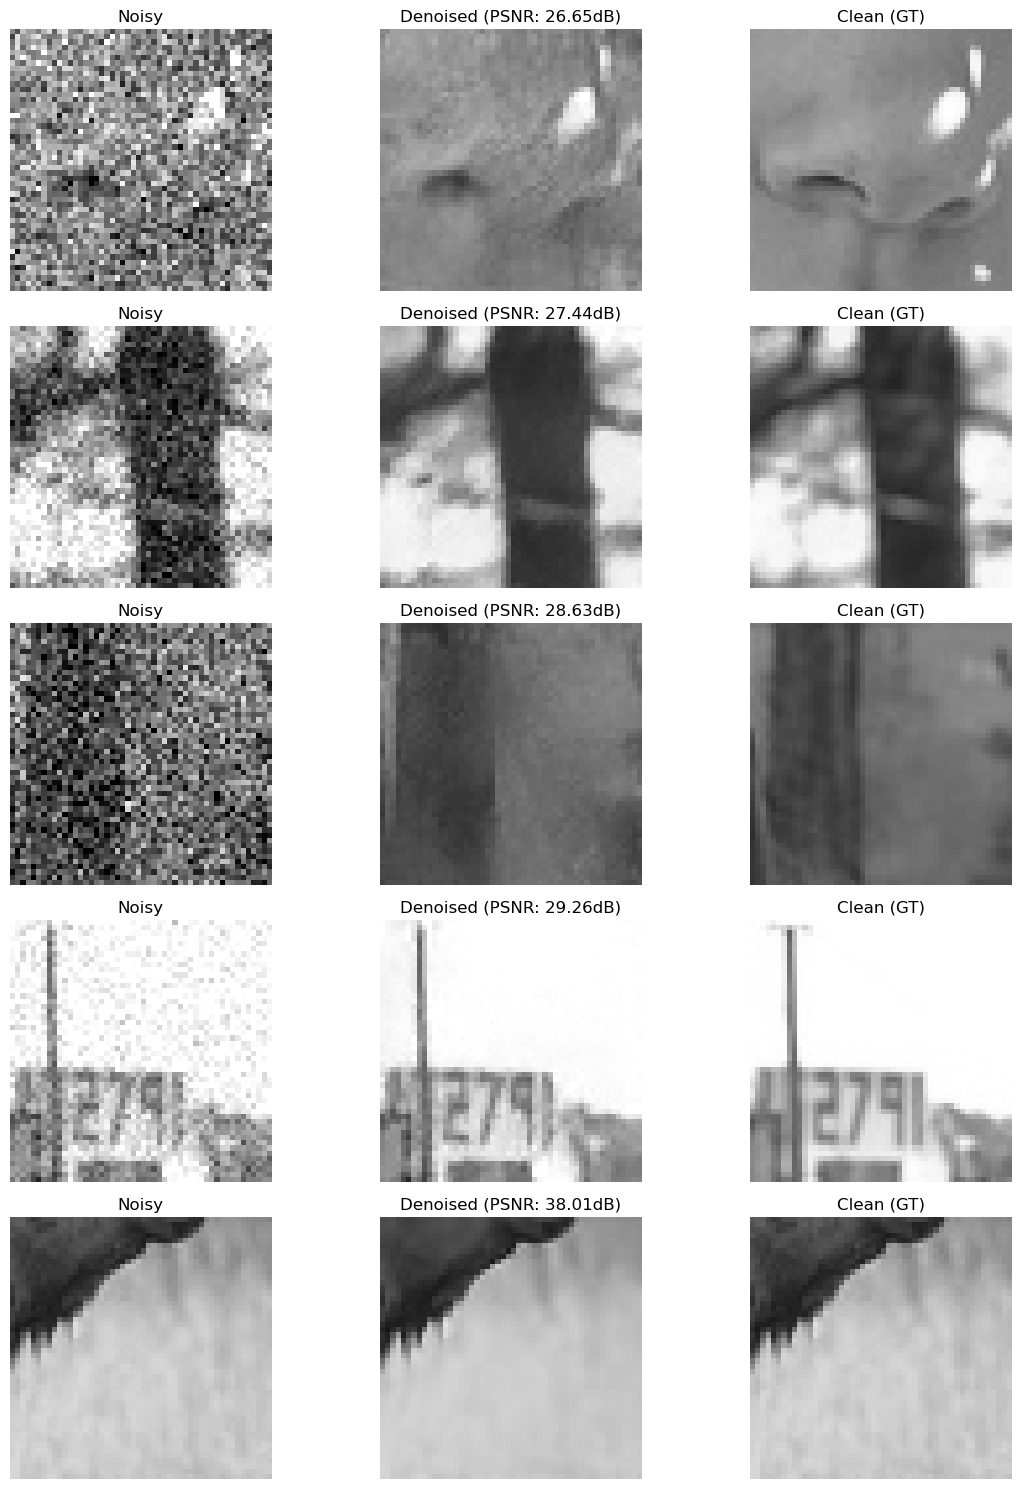

In [61]:
# 학습 시작
history = train_gan(
    generator, discriminator, perceptual,
    adv_loss, mse_loss,
    optimizer_G, optimizer_D,
    train_loader, val_loader,
    device, config
)

# 결과 시각화
plot_results(history)
print('\nDenoising Results:')
show_denoising_results(generator, val_loader, device, num_samples=5)